The NLR7301 is a supercritical airfoil which has been modified to a two-element configuration with a non-retractable flap. This configuration and the measurements were designed for the purpose of CFD validation[1]. The measurements were taken in 1979 and includes detailed pressure distributions, transition onset locations and someboundary layer velocity profiles for the angles of attack 6° and 13.1°. These measurements have been used extensively for another viscid-inviscid interaction method[2] as well as Navier Stokes codes, e.g.[3]. There is only a single measurement set available, at a Reynolds Number of 2.51E6 and a Mach Number of .185, comprising a set of 16 lift and 3 drag values. In the following, the results of viiflow using the Integral Boundary Layer Equations and the Panel Method with a Prandtl-Glauert correction are compared to these measurements.

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [11, 6] # Make plots bigger than default

# Read Airfoil Data
MAIN = vft.repanel_spline(vft.read_selig("NLR7301.dat"),260) #180
FLAP = vft.repanel_spline(vft.read_selig("NLR7301FLAP.dat"),220) #150

## Geometry, Angle of Attack and Flap

A few notes on the measurement and the geometry are in order. The geometry of the configuration was obtained from the appendix of a thesis[4] as the geometry is not part of the experiment description.
Another source of geometrical error is the placement and angle of the flap. Below, a picture of the two source document geometries and the used geometry from the thesis are compared.

<img src="geocomparison.png" alt="Comparison" style="width: 700px;"/>

*Comparison between the geometries of the two measurement publications (black) and the used geometry (blue).*


Matching the geometry with the image from the experiment looks quite good, but the angles of attack might differ from the geometry and the experiment. This shift means that the angle of attack of the experimental data is shifted by -.5°, i.e. a bit to the left. This shift is a bit larger than the margin or error seen by comparing the geometries in an image editor. There, a rotation of .3° of the data in the original document from 1979 leads to a better fit between the main airfoil shapes while rotating the flap in the used geometry by 0.2° up to 0.5° looks better in comparison to the documents.
All of this is said because the results below are compared to shifted results, which are matching the computations better. The discussion below will compare the shifted results (and not constantly note the better fit if the data was shifted).

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0.185 using a Prandtl-Glauert correction for the pressure and lift. Like in the S805 example a critical amplification factor of 10.2 was used, even though for the Delft low-speed wind tunnel 11.2 seems to be recommended[5]. The G-beta locus constants were set to XFOIL defaults. This combination leads to a very good agreement in maximum lift between experiment and calculation.

In [2]:
# Settings
RE = 2.51e6
ncrit = 10.2
Mach = 0.185
AOArange = np.arange(-2,16,.5)

s = vf.setup(Re=RE,ncrit=ncrit,Ma=Mach,alpha=AOArange[0])
s.iterate_wakes = False # Re-calculate wake shape at every iteration
s.itermax = 100 # Iterations before returning to Python
s.silent = False # Show information on convergence and itaerations

# For this problem the XFOIL locus constants lead to a better fit with maximum lift.
# Set to XFOIL constants
s.LocusA = 6.70
s.LocusB = 0.75
s.substeps = 2

# Set-up and initialize ba on inviscid panel solution
[p,bl,x] = vf.init([MAIN,FLAP],s)

results = {} # Dictionary of results
valv = [0.185] # Maybe use a set of Mach numbers for comparison!
for val in valv:
    xn = x.copy()
    results[val] = {}
    results[val]["AOA"] = []
    results[val]["CL"] = []
    results[val]["CD"] = []
    s.ncrit = ncrit
    s.Ma = val

    for alpha in AOArange:
        s.alpha = alpha
        res = None
        grad = None
        for it in range(5):
            [xn,flag,res,_,_] = vf.iter(xn,bl,p,s,res,grad)
            if np.sqrt(np.dot(res.T,res))<2e-3:
                results[val]["AOA"].append(alpha)
                results[val]["CL"].append(p.CL)
                results[val]["CD"].append(bl[0].CD+bl[1].CD)
                break


Iteration 36, |res| 0.000778, lam 0.786967
Iteration 6, |res| 0.000914, lam 0.500000
Iteration 6, |res| 0.000771, lam 0.500000
Iteration 6, |res| 0.000606, lam 0.508976
Iteration 6, |res| 0.000767, lam 0.500000
Iteration 4, |res| 0.000992, lam 0.855737
Iteration 6, |res| 0.000587, lam 0.500000
Iteration 7, |res| 0.000639, lam 0.500000
Iteration 6, |res| 0.000903, lam 0.500000
Iteration 9, |res| 0.000721, lam 0.500000
Iteration 6, |res| 0.000970, lam 0.500000
Iteration 7, |res| 0.000642, lam 0.500000
Iteration 5, |res| 0.000690, lam 0.691310
Iteration 8, |res| 0.000983, lam 0.500000
Iteration 10, |res| 0.000717, lam 0.500000
Iteration 9, |res| 0.000901, lam 0.500000
Iteration 7, |res| 0.000746, lam 0.500000
Iteration 7, |res| 0.000745, lam 0.500000
Iteration 8, |res| 0.000604, lam 0.500000
Iteration 7, |res| 0.000589, lam 0.560667
Iteration 5, |res| 0.000825, lam 0.709077
Iteration 5, |res| 0.000952, lam 0.722321
Iteration 10, |res| 0.000571, lam 0.597309
Iteration 10, |res| 0.000984, l

Iteration 9, |res| 0.000674, lam 0.500000
Iteration 8, |res| 0.000905, lam 0.500000
Iteration 9, |res| 0.000861, lam 0.500000
Iteration 7, |res| 0.000634, lam 0.500000


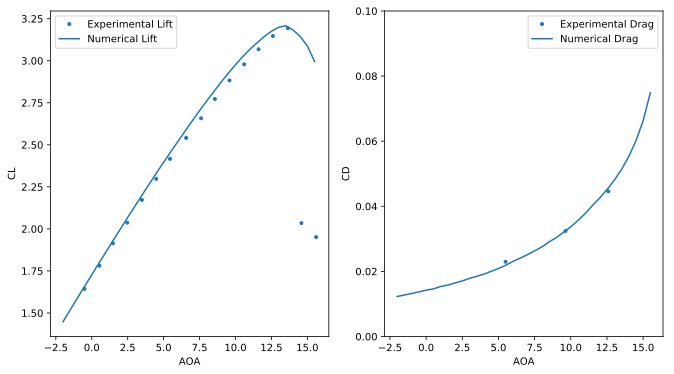

In [5]:
# Read experimental data
EXPRES=np.genfromtxt("NLRLIFTSLOPE.csv",delimiter=",",names=True)

fix,ax = plt.subplots(1,2)
ax[0].plot(EXPRES['MEASSHIFT_X'],EXPRES['MEASSHIFT_Y'],marker=".",linestyle = 'None', color="tab:blue")
for val in valv:
    ax[0].plot(np.array(results[val]["AOA"]),results[val]["CL"],marker=None)
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[0].legend(['Experimental Lift','Numerical Lift'])

EXPRES=np.genfromtxt("NLRDRAGSLOPE.csv",delimiter=",",names=True)
ax[1].plot(EXPRES['MEASSHIFT_X'],EXPRES['MEASSHIFT_Y'],marker=".",linestyle = 'None', color="tab:blue")
for val in valv:
    ax[1].plot(results[val]["AOA"],results[val]["CD"],marker=None)
ax[1].set_xlabel('AOA')
ax[1].set_ylabel('CD')
ax[1].set_ylim([0, 0.1])
ax[1].legend(['Experimental Drag','Numerical Drag']);

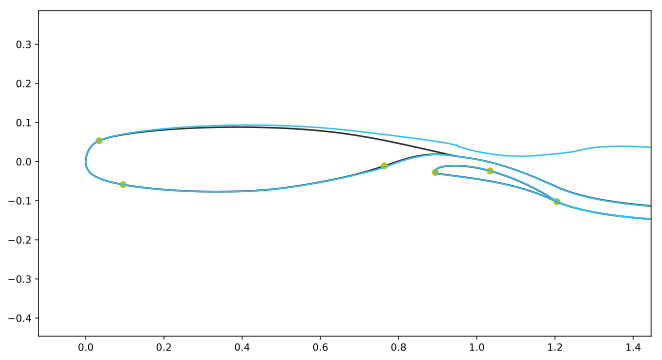

In [6]:
# Plot solution at last AOA
lines = None
fig,ax = plt.subplots(1,1)
vfp.plot_geometry(ax,p,bl,None);

## Pressure Distributions
To compare the pressure distribution to those from the literature, the angles of interest are re-calculated and the boundary layer and panel objects saved. One could as well only save the vectors of interest instead of the whole objects.
Here, the shifted and original coefficients are compared. 

The main airfoil pressure distribution matches very well with the experiments, regardless of shift. The transition on the pressure side is slightly delayed compared to the experiment. On the flap the experiment and prediction differ significantly. The most important difference is the change of velocity due to transition on the suction side, while the point of transition is well matched. Viiflow predicts a drop in velocity after transition, while the experiments indicate a smooth transition.

In [7]:
# Set-up and initialize based on inviscid panel solution
import copy
s.itermax = 200
s.iterate_wakes=False

s.alpha = 5.5
[p5,bl5,x] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl5,p5,s,None,None)

s.alpha = 6
[p6,bl6,_] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl6,p6,s,None,None)

s.alpha = 12.6
[p12,bl12,_] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl12,p12,s,None,None)

s.alpha = 13.1
[p13,bl13,_] = vf.init([MAIN,FLAP],s)
[x,flag,res,_,_] = vf.iter(x,bl13,p13,s,None,None);

Iteration 37, |res| 0.000974, lam 0.500000
Iteration 7, |res| 0.000731, lam 0.500000
Iteration 25, |res| 0.000941, lam 0.500000
Iteration 8, |res| 0.000744, lam 0.500000


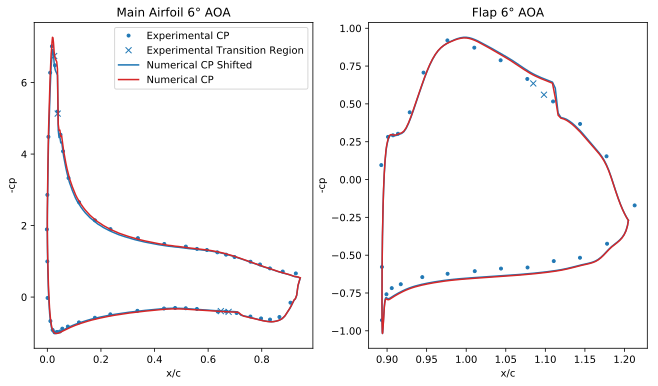

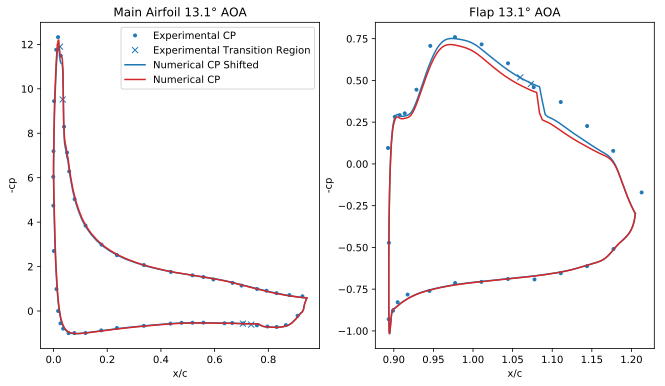

In [8]:
PG = np.sqrt(1-0.185**2) # Prandtl Glauert factor

# Read and plot data for 6° AoA
EXPRES=np.genfromtxt("NLRCP55.csv",delimiter=",",names=True)
fix,ax = plt.subplots(1,2)
ax[0].plot(EXPRES['EXPMAINCP_X'],EXPRES['EXPMAINCP_Y'],marker=".",linestyle = 'None', color="tab:blue")
ax[1].plot(EXPRES['EXPFLAPCP_X'],EXPRES['EXPFLAPCP_Y'],marker=".",linestyle = 'None', color="tab:blue")
ax[0].plot(EXPRES['EXPMAINTR_X'],EXPRES['EXPMAINTR_Y'],marker="x",linestyle = 'None', color="tab:blue")
ax[1].plot(EXPRES['EXPFLAPTR_X'],EXPRES['EXPFLAPTR_Y'],marker="x",linestyle = 'None', color="tab:blue")
ax[0].plot(np.array(p.foils[0].X[0,:]),(bl5[0].bl_fl.nodes.ue**2-1)/PG,marker="None",color="tab:blue")
ax[1].plot(np.array(p.foils[1].X[0,:]),(bl5[1].bl_fl.nodes.ue**2-1)/PG,marker="None",color="tab:blue")
ax[0].plot(np.array(p.foils[0].X[0,:]),(bl6[0].bl_fl.nodes.ue**2-1)/PG,marker="None",color="tab:red")
ax[1].plot(np.array(p.foils[1].X[0,:]),(bl6[1].bl_fl.nodes.ue**2-1)/PG,marker="None",color="tab:red")
ax[0].set_xlabel('x/c')
ax[0].set_ylabel('-cp')
ax[1].set_xlabel('x/c')
ax[1].set_ylabel('-cp')
ax[0].legend(['Experimental CP','Experimental Transition Region','Numerical CP Shifted','Numerical CP'])
ax[0].set_title('Main Airfoil 6° AOA')
ax[1].set_title('Flap 6° AOA')

# Read and plot data for 13.1° AoA
EXPRES=np.genfromtxt("NLRCP126.csv",delimiter=",",names=True)
fix,ax = plt.subplots(1,2)
ax[0].plot(EXPRES['EXPMAINCP_X'],EXPRES['EXPMAINCP_Y'],marker=".",linestyle = 'None', color="tab:blue")
ax[0].plot(EXPRES['EXPMAINTR_X'],EXPRES['EXPMAINTR_Y'],marker="x",linestyle = 'None', color="tab:blue")
ax[1].plot(EXPRES['EXPFLAPCP_X'],EXPRES['EXPFLAPCP_Y'],marker=".",linestyle = 'None', color="tab:blue")
ax[1].plot(EXPRES['EXPFLAPTR_X'],EXPRES['EXPFLAPTR_Y'],marker="x",linestyle = 'None', color="tab:blue")
ax[0].plot(np.array(p.foils[0].X[0,:]),(bl12[0].bl_fl.nodes.ue**2-1)/PG,marker="None", color="tab:blue")
ax[1].plot(np.array(p.foils[1].X[0,:]),(bl12[1].bl_fl.nodes.ue**2-1)/PG,marker="None", color="tab:blue")
ax[0].plot(np.array(p.foils[0].X[0,:]),(bl13[0].bl_fl.nodes.ue**2-1)/PG,marker="None", color="tab:red")
ax[1].plot(np.array(p.foils[1].X[0,:]),(bl13[1].bl_fl.nodes.ue**2-1)/PG,marker="None", color="tab:red")
ax[0].set_xlabel('x/c')
ax[0].set_ylabel('-cp')
ax[1].set_xlabel('x/c')
ax[1].set_ylabel('-cp')
ax[0].legend(['Experimental CP','Experimental Transition Region','Numerical CP Shifted','Numerical CP'])
ax[0].set_title('Main Airfoil 13.1° AOA')
ax[1].set_title('Flap 13.1° AOA');


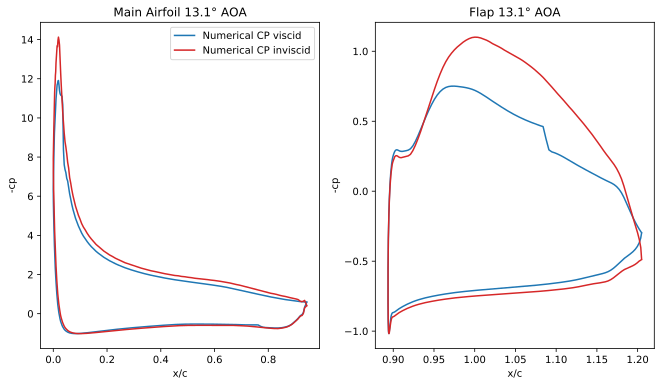

In [9]:
# Compare Viscid/Inviscid CP
fix,ax = plt.subplots(1,2)
ax[0].plot(np.array(p.foils[0].X[0,:]),(bl12[0].bl_fl.nodes.ue**2-1)/PG,marker="None", color="tab:blue")
ax[1].plot(np.array(p.foils[1].X[0,:]),(bl12[1].bl_fl.nodes.ue**2-1)/PG,marker="None", color="tab:blue")
ax[0].plot(np.array(p.foils[0].X[0,:]),(np.power(p12.gamma_inviscid[0:p.foils[0].N,0],2)-1)/PG,marker="None", color="tab:red")
ax[1].plot(np.array(p.foils[1].X[0,:]),(np.power(p12.gamma_inviscid[p.foils[0].N:p.foils[0].N+p.foils[1].N,0],2)-1)/PG,marker="None", color="tab:red")
ax[0].set_xlabel('x/c')
ax[0].set_ylabel('-cp')
ax[1].set_xlabel('x/c')
ax[1].set_ylabel('-cp')
ax[0].legend(['Numerical CP viscid','Numerical CP inviscid'])
ax[0].set_title('Main Airfoil 13.1° AOA')
ax[1].set_title('Flap 13.1° AOA');

[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun H. Chen. *An interactive boundary-layer method for multielement airfoils.* Computers & fluids 27.5 (1998): 651-661.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.